In [1]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Tuple
from pathlib import Path
from torch.utils.data import DataLoader

from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.config import Config


In [2]:
mpl.rcParams["grid.color"] = "#eeeeee"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 11})

### Train model with negative logarithm of the likelihood

In [3]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("DE_4_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("DE_4_basin.yml"), gpu=-1)

2024-11-12 15:47:26,160: Logging to /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/hourly/single_basin_multi_forcing_MDN/DE4_riefensbeek_soese/runs/hourlylstm_seed32_1211_154726/output.log initialized.
2024-11-12 15:47:26,160: ### Folder structure created at /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/hourly/single_basin_multi_forcing_MDN/DE4_riefensbeek_soese/runs/hourlylstm_seed32_1211_154726
2024-11-12 15:47:26,160: ### Run configurations for hourlylstm_seed32
2024-11-12 15:47:26,161: experiment_name: hourlylstm_seed32
2024-11-12 15:47:26,161: train_basin_file: basin.txt
2024-11-12 15:47:26,161: validation_basin_file: basin.txt
2024-11-12 15:47:26,161: test_basin_file: basin.txt
2024-11-12 15:47:26,161: train_start_date: 2000-01-01 00:00:00
2024-11-12 15:47:26,162: train_end_date: 2019-09-30 00:00:00
2024-11-12 15:47:26,162: validation_start_date: 2020-10-01 00:00:00
2024-11-12 15:47:26,162: validation_end_date: 2022-09-30 00:00:00
2024-11-12 15:47:26,162: test_start_date: 

### Evaluate run on test set
The path to the best model is automatically saved in the variable best_model, and the corresponding best epoch is stored as a string in best_epoch.

In [4]:
run_dir = Path("runs/hourlylstm_seed32_1211_154726")

In [ ]:
eval_run(run_dir=run_dir, period="test")

2024-11-13 08:04:06,549: Using the model weights from runs/hourlylstm_seed32_1211_154726/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [02:07<00:00, 127.12s/it]
2024-11-13 08:06:13,675: Stored metrics at runs/hourlylstm_seed32_1211_154726/test/model_epoch050/test_metrics.csv
2024-11-13 08:06:13,844: Stored results at runs/hourlylstm_seed32_1211_154726/test/model_epoch050/test_results.p


### Load and inspect model predictions
Load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [5]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['DE4'])

In [6]:
results['DE4']['1h']['xr']['discharge_vol_sim']

<xarray.DataArray 'discharge_vol_sim' (date: 10968, time_step: 1, samples: 7500)>
array([[[ 8.851957 ,  7.5687304,  9.494096 , ...,  9.685963 ,
          9.428845 ,  9.946712 ]],

       [[10.053749 ,  8.535183 ,  9.550635 , ...,  8.583015 ,
         11.873921 ,  8.220822 ]],

       [[11.126328 ,  9.760299 ,  9.976755 , ...,  9.261119 ,
         10.052605 ,  8.545705 ]],

       ...,

       [[33.639988 , 33.536343 , 34.0502   , ..., 27.579033 ,
         35.18198  , 33.65928  ]],

       [[43.55462  , 26.156824 , 35.90058  , ..., 31.644314 ,
         29.458061 , 39.642914 ]],

       [[29.997318 , 30.979206 , 36.469772 , ..., 35.43263  ,
         32.495884 , 32.80871  ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2022-10-01 ... 2023-12-31T23:00:00
  * time_step  (time_step) int64 0
Dimensions without coordinates: samples

In [15]:
# Extract observations and simulations
qobs = results['DE4']['1h']['xr']['discharge_vol_obs']
qsim = results['DE4']['1h']['xr']['discharge_vol_sim']

In [26]:
qsim['date']

<xarray.DataArray 'date' (date: 10968)>
array(['2022-10-01T00:00:00.000000000', '2022-10-01T01:00:00.000000000',
       '2022-10-01T02:00:00.000000000', ..., '2023-12-31T21:00:00.000000000',
       '2023-12-31T22:00:00.000000000', '2023-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2022-10-01 ... 2023-12-31T23:00:00

In [27]:
qobs['date']

<xarray.DataArray 'date' (date: 10968)>
array(['2022-10-01T00:00:00.000000000', '2022-10-01T01:00:00.000000000',
       '2022-10-01T02:00:00.000000000', ..., '2023-12-31T21:00:00.000000000',
       '2023-12-31T22:00:00.000000000', '2023-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2022-10-01 ... 2023-12-31T23:00:00

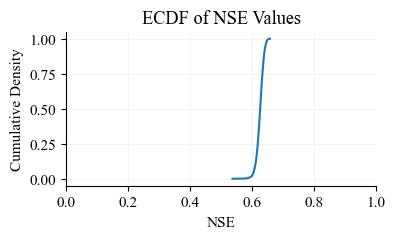

In [11]:
# Define the NSE calculation function
def nse(obs, sim):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) between observed and simulated data.
    
    Parameters:
    obs (np.ndarray): Observed data array of shape (823,)
    sim (np.ndarray): Simulated data array of shape (823,)
    
    Returns:
    float: NSE value
    """
    # Ensure inputs are 1D numpy arrays
    obs = np.asarray(obs).flatten()
    sim = np.asarray(sim).flatten()
    
    # Calculate numerator and denominator for NSE
    denominator = np.sum((obs - np.mean(obs))**2)
    numerator = np.sum((sim - obs)**2)
    
    # Calculate NSE
    value = 1 - numerator / denominator
    return value

# Load or assign the observed data (shape: 823 x 1)
# Replace '...' with your actual data loading code
obs_data = qobs  # xarray.DataArray of shape (823, 1)
obs = obs_data.values.flatten()  # Convert to 1D numpy array of shape (823,)

# Load or assign the simulated data (shape: 823 x 1 x 1000)
# Replace '...' with your actual data loading code
sim_data = qsim  # xarray.DataArray of shape (823, 1, 1000)

# Number of samples (should be 1000)
num_samples = sim_data.shape[2]

# Initialize a list to store NSE values
nse_values = []

# Loop over each sample to calculate NSE
for i in range(num_samples):
    # Extract simulated data for the i-th sample (shape: 823,)
    sim_sample = sim_data[:, 0, i]
    
    # Calculate NSE between observed data and simulated sample
    nse_i = nse(obs, sim_sample)
    
    # Append the NSE value to the list
    nse_values.append(nse_i)

# Convert the list of NSE values to a numpy array
nse_values = np.array(nse_values)

# Sort the NSE values in ascending order
nse_sorted = np.sort(nse_values)

# Calculate cumulative probabilities for the ECDF
cum_probs = np.arange(1, len(nse_sorted) + 1) / len(nse_sorted)

# Plot the ECDF
plt.figure(figsize=(4, 2))
plt.plot(nse_sorted, cum_probs, linestyle='-')
plt.xlabel('NSE')
plt.ylabel('Cumulative Density')
plt.title('ECDF of NSE Values')
plt.xlim(0, 1)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

In [35]:
qobs

<xarray.DataArray 'discharge_vol_obs' (date: 10968, time_step: 1)>
array([[ 8.3  ],
       [ 8.3  ],
       [ 8.3  ],
       ...,
       [24.075],
       [24.   ],
       [24.   ]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2022-10-01 ... 2023-12-31T23:00:00
  * time_step  (time_step) int64 0

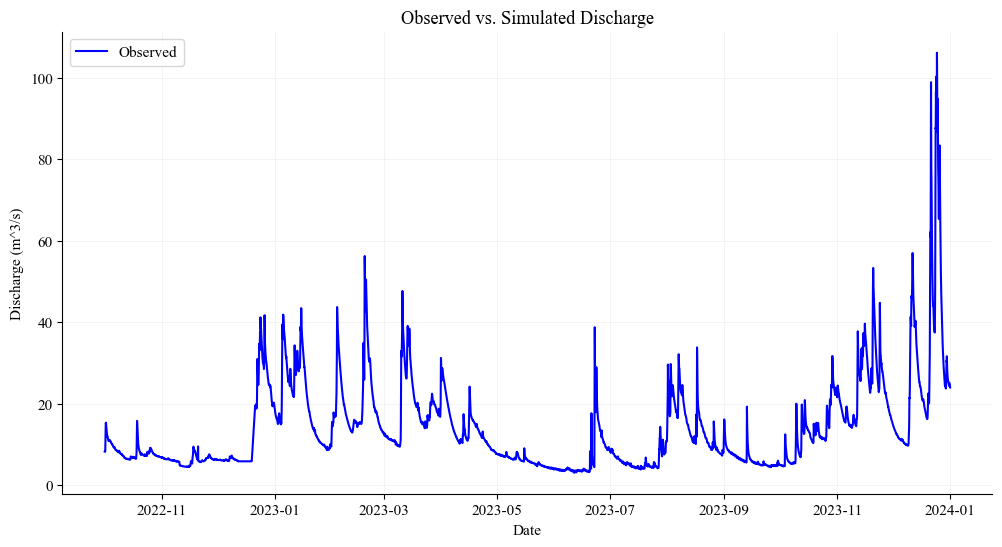

In [34]:
# plot qobs
plt.figure(figsize=(12, 6))
plt.plot(qobs['date'], qobs, label='Observed', color='blue')
plt.legend()
plt.title('Observed vs. Simulated Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge (m^3/s)')
plt.grid(True)
plt.show()

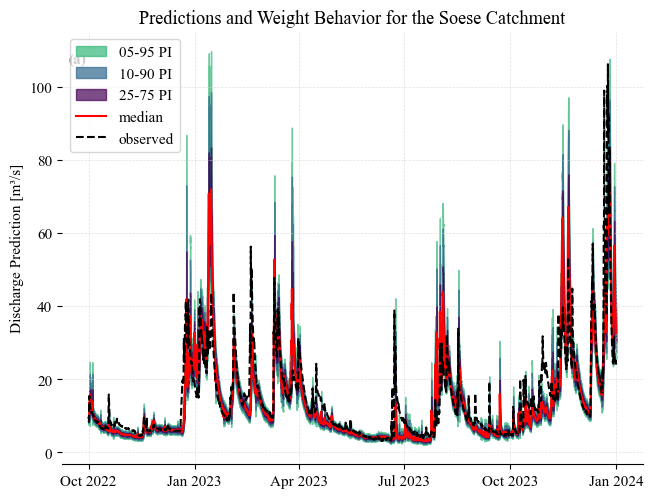

In [23]:
# Set up the plotting area with specified dimensions
figwidth = 17 # cm
figheight = 13 # cm

def cm2inch(width: float, height: float) -> Tuple[float, float]:
    """Converts figure size from centimeters to inch."""
    inch = 2.54
    return (width / inch, height / inch)

# Create the plot of given size
fig, ax = plt.subplots(1, 1, figsize=cm2inch(figwidth, figheight))

# First subplot (Predictions)
y_median = np.median(qsim, axis=-1).flatten()
y_25 = np.percentile(qsim, 25, axis=-1).flatten()
y_75 = np.percentile(qsim, 75, axis=-1).flatten()
y_10 = np.percentile(qsim, 10, axis=-1).flatten()
y_90 = np.percentile(qsim, 90, axis=-1).flatten()
y_05 = np.percentile(qsim, 5, axis=-1).flatten()
y_95 = np.percentile(qsim, 95, axis=-1).flatten()

# Plotting in the first subplot
ax.fill_between(qsim['date'], y_05, y_95, color='#35B779', label='05-95 PI', alpha=0.7)
ax.fill_between(qsim['date'], y_10, y_90, color='#31688E', label='10-90 PI', alpha=0.7)
ax.fill_between(qsim['date'], y_25, y_75, color="#440154", label='25-75 PI', alpha=0.7)
ax.plot(qsim['date'], y_median, '-', color='red', label="median")
ax.plot(qsim['date'], qobs, '--', color='black', label="observed")

# Format the x-ticks and remove unnecessary spines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year'
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

# Axis labels, title, grid, and legend for ax1
ax.set_ylabel('Discharge Prediction [m³/s]')
ax.legend()
ax.set_title('Predictions and Weight Behavior for the Soese Catchment')
ax.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)
ax.text(0.01, 0.95, "(a)", transform=ax.transAxes, verticalalignment='top', fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as pdf
# plt.savefig('DE4_predictions_and_weights.pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [36]:
import numpy as np
import plotly.graph_objs as go
import pandas as pd
import xarray as xr

# Assuming qsim is a pandas dataframe and qobs is an xarray DataArray
# Replace qsim and qobs with your actual data accordingly

# Generate median, percentile values
y_median = np.median(qsim, axis=-1).flatten()
y_25 = np.percentile(qsim, 25, axis=-1).flatten()
y_75 = np.percentile(qsim, 75, axis=-1).flatten()
y_10 = np.percentile(qsim, 10, axis=-1).flatten()
y_90 = np.percentile(qsim, 90, axis=-1).flatten()
y_05 = np.percentile(qsim, 5, axis=-1).flatten()
y_95 = np.percentile(qsim, 95, axis=-1).flatten()

# Create the plotly figure
fig = go.Figure()

# Add filled areas for the prediction intervals
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_95,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='95th Percentile',
))
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_05,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(53, 183, 121, 0.7)',
    line=dict(width=0),
    name='05-95 PI',
))
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_90,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='90th Percentile',
))
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_10,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(49, 104, 142, 0.7)',
    line=dict(width=0),
    name='10-90 PI',
))
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_75,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='75th Percentile',
))
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_25,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(68, 1, 84, 0.7)',
    line=dict(width=0),
    name='25-75 PI',
))

# Add the median line
fig.add_trace(go.Scatter(
    x=qsim['date'], y=y_median,
    mode='lines',
    line=dict(color='red', width=2),
    name='Median'
))

# Add the observed data
fig.add_trace(go.Scatter(
    x=qobs['date'].values, y=qobs.values.flatten(),
    mode='lines',
    line=dict(color='black', width=2, dash='dash'),
    name='Observed'
))

# Update the layout for better appearance
fig.update_layout(
    title='Predictions and Weight Behavior for the Soese Catchment',
    xaxis_title='Date',
    yaxis_title='Discharge Prediction [m³/s]',
    xaxis=dict(
        tickformat='%b %Y',
        dtick="M3",  # Show every 3 months
    ),
    legend=dict(
        x=0.01, y=0.99
    ),
    template='plotly_white'
)

# Show the figure
fig.show()